University of Helsinki, Master's Programme in Data Science  
DATA20047 Probabilistic Cognitive Modelling - Spring 2023  
Luigi Acerbi  

# Problem Set 4: Combining inference with utility, and everything

- This homework problem set focuses on **Week 7** of the course, plus a recap of everything we have done in the course.
- This problem set is worth **30 points** in total (out of 100 for the full course).
- Check the submission deadline on Moodle! **Note that the deadline is at noon.**


## Submission instructions

Submission must be perfomed entirely on Moodle (**not** by email).
1. When you have completed the exercises, save the notebook.
2. Report your solutions and answers on Moodle ("*Problem set 4 answer return*").
3. Submit two files on Moodle ("*Problem set 4 notebook return*"): 
  - The notebook as `.ipynb`.
  - The same notebook downloaded as `.pdf` (there are various ways to save the file as PDF, the most general is "File" > "Print Preview" and then print the page to PDF using your browser - remember to enter the Print Preview first).

## IMPORTANT

1. Do not share your code and answers with others. Contrary to the class exercises, which you can do with others, these problems are *not* group work and must be done individually.
2. It is allowed to use snippets of code from the lecture exercises and model solutions.
3. It is your responsibility to ensure that the notebook has fully finished running all the cells, all the plots view properly etc. before submitting it. However, the notebook should be runnable from scratch if needed ("Kernel > Restart & Run All").
4. Submit your work by the deadline.
5. Unless stated otherwise, please report your numerical answers in Moodle with full numerical precision (~14-15 digits), unless the answer is an integer.
6. If you are confused, think there is a mistake or find things too difficult, please ask on Moodle.

## References

- \[**MKG22**\] Ma WJ, Körding K, and Goldreich D. "Bayesian Models of Perception and Action: An Introduction". MIT Press, 2022.
- \[**AWV12**\] Acerbi L, Wolpert DM, Vijayakumar S. "Internal Representations of Temporal Statistics and Feedback Calibrate Motor-Sensory Interval Timing". *PLoS Computational Biology*, 2012. [Link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002771)

In [9]:
# set-up -- do not change
#789 10 11 12
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
npr.seed(1)

# Question 4.1 (6 pts)

> In this question, we will look at the optimal aim location when playing a modified game of darts.

Assume you are playing a game of darts, that is you need to throw a dart at a target a couple of meters away from you. For simplicity, we assume this is a modified version of the game in which the target board comprises of a series of vertical bands, so that only the horizontal landing location of the dart matters. Landing the dart on each different sector is associated with a different score.

We measure horizontal location starting from the center of the dart board ($0$ cm), with negative numbers meaning a position to the left of the center and positive numbers a position to the right of the center. We ignore the vertical position, assuming the bands are tall enough to be easy to hit on the vertical axis.

The sectors are characterized by their bounds on the board (start and end location) and their score, as follows:

- -25 to -15 cm: 15 points.
- -15 to -5 cm: 10 points.
- -5 to 5 cm: 20 points.
- 5 to 15 cm: 5 points.
- 15 to 25 cm: 25 points.

If the dart lands outside the board, you would get 0 points.

Given the aim location $\hat{s}$, we assume that due to motor noise, the actual *hit* location $r$ (where the dart actually lands) is distributed as follows:
$$
p(r|\hat{s}) = (1-\lambda) \mathcal{N}\left(r; \hat{s},\sigma^2_\text{motor}\right) + \lambda \mathcal{N}\left(r; \hat{s},\sigma^2_\text{lapse}\right),
$$
where $\sigma_\text{motor}$ is the standard spread location due to motor error and throwing variability. The novelty of this equation is that we also consider a probability $\lambda \in [0, 1]$ of lapsing (e.g., sneezing or being distracted by a friend while throwing), which produces a bad throw with a larger error $\sigma_\text{lapse}$. For this exercise, we assume $\sigma_\text{lapse} = 20$ cm.

Write a function that computes the expected score as a function of aim location $\hat{s}$ and task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$. Then, write a function that for given task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$, returns the optimal aim location $s^\star$ (the aim point which produces the maximum expected score).

- a) For $\sigma_\text{motor} \in [2, 10]$ cm and $\lambda \in [0, 0.2]$, what are the rightmost (maximum) and leftmost (minimum) locations for $s^\star$?
- b) For $\lambda = 0.1$, plot $s^\star$ as a function of $\sigma_\text{motor}$, for $\sigma_\text{motor} \in [2, 10]$ cm. You should see an interesting switch of optimal strategy. Around which value of $\sigma_\text{motor}$ the optimal strategy switches and it becomes more convenient to throw the dart to the left of the center as opposed to the right of the center?

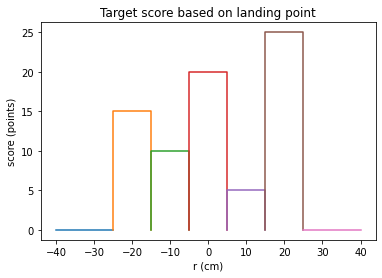

In [10]:
bands = [-np.inf,-25,-15,-5,5,15,25,np.inf]
scores = [0,15,10,20,5,25,0]

# Plot target score

s = np.linspace(-30,30,200)
for index, band in enumerate(scores):
    a = np.maximum(bands[index], -40)
    b = np.minimum(bands[index+1], 40)
    plt.plot((a,a,b,b),np.array((0,scores[index],scores[index],0)))

plt.xlabel('r (cm)')
plt.ylabel('score (points)')
plt.title('Target score based on landing point')
plt.show()

In [269]:
import numpy as np
from scipy.stats import norm
def get_score(hit):
    scores = []
    for i in range(len(hit)):
        if -25 <=hit[i] and hit[i]< -15:
            scores.append(15)
            continue
        if -15 <=hit[i] and hit[i]< -5:
            scores.append(10)
            continue
        if -5 <= hit[i] and hit[i]< 5:
            scores.append(20)
            continue
        if 5 <=hit[i] and hit[i]< 15:
            scores.append(5)
            continue
        if 15 <=hit[i] and hit[i]<= 25:
            scores.append(25)
            continue
        if 25 < hit[i] or hit[i]< -25:
            scores.append(0)
            continue
    return scores
def expected_score(s_hat, sigma_motor, lmbda, sigma_lapse):
    hit = np.linspace(-41, 41, 2**8+1)
    dr = hit[1] - hit[0]
    scores = get_score(hit)
    p_hit = (1 - lmbda) * norm.pdf(hit, loc=s_hat, scale=sigma_motor) + lmbda * norm.pdf(hit, loc=s_hat, scale=sigma_lapse)
    const = sp.integrate.romb(p_hit, dx=dr, axis=0)
    posterior = p_hit / const
    expected = sp.integrate.romb(posterior * scores, axis=0)
    return expected

In [270]:
def find_optimal_aim_location(sigma_motor, lambd, sigma_lapse):
    results = []
    for s_hat in np.linspace(-25, 25, 200):
        score = expected_score(s_hat, sigma_motor, lambd, sigma_lapse)
        results.append(score)
    print(results)
    s_star = np.linspace(-25, 25, 200)[np.argmax(results)]
    return s_star

In [ ]:
sigma_motor_range = np.linspace(2, 10, 80)
lmbda_range = np.linspace(0, 0.2, 20)
optimal_locations = np.zeros((len(sigma_motor_range), len(lmbda_range)))
for i, sigma_motor in enumerate(sigma_motor_range):
    for j, lmbda in enumerate(lmbda_range):
        optimal_locations[i, j] = find_optimal_aim_location(sigma_motor, lmbda, 20)
rightmost = np.max(optimal_locations)
leftmost = np.min(optimal_locations)

In [272]:
print(f"Rightmost optimal aim location: {rightmost:.10f} cm")
print(f"Leftmost optimal aim location: {leftmost:.10f} cm")

Rightmost optimal aim location: 19.9748743719 cm
Leftmost optimal aim location: -1.8844221106 cm


In [ ]:
s_star = []
for sigma_motor in sigma_motor_range:
    s_star.append(find_optimal_aim_location(sigma_motor, 0.1,20))
plt.plot(sigma_motor_range, s_star)
plt.xlabel('sigma_motor')
plt.ylabel('optimal aim location (cm)')
plt.title('Optimal aim location as a function of sigma_motor')
plt.show()

In [276]:
s_star[58]

16.959798994974868

In [278]:
sigma_motor_range[59]

7.974683544303797

# Question 4.2 (6 pts)

> In this question, we will infer the empirical loss function of an observer in a task based on their responses.

In each trial of this experiment, the participant is shown a cloud of dots on a screen. The horizontal location of each dot is drawn from the following mixture distribution:
  $$
  p(s; h) = 0.8 \mathcal{N}\left(s; 0, 0.2^2\right) + 0.2 \mathcal{N}\left(s; h, 0.2^2\right)
  $$
  where $h$ is a parameter controlled by the experimenter, and is changed from trial to trial. The horizontal location is measured in normalized screen units $s \in [-1, 1]$, where $0$ is the center of the screen. 
- Along the vertical axis, the dots show a small jitter along the center of the screen (we ignore the vertical displacement).
- In each trial, the subject is asked to report the horizontal position of the *center* of the cloud of dots. The word "center" is ambiguous, as we could be asking for the mean, the median, or other [measures of central tendency](https://en.wikipedia.org/wiki/Central_tendency). The question is what the subject would naturally report. We assume the subject reports the estimate $\hat{s}$ that minimizes their expected loss. 
- For the purpose of this question, we also assume that the observer's loss function takes the parametric form
  $$
  \mathcal{L}_\alpha\left(s^\prime, s \right) = \left| s^\prime - s \right|^\alpha
  $$
  which is the loss for reporting $s^\prime$ for a dot position $s$. 
- In each trial, the expected loss is the expectation of the loss over the presented dot locations, $p(s; h)$.
- A sequence of trials is thus represented by the trial design (the presented distribution of dots, parameterized by $h_t$) and the observer's responses $\hat{s}_t$ in each trial $t$.
- For simplicity, here we assume that there is no response noise.

Given the data reported below, infer the exponent $\alpha \ge 0$ of the loss function that best describes the subject behavior. Do so by finding the $\alpha$ that minimizes the squared error between the model prediction (assuming the observer follows Bayesian decision theory) and the data. Report the best estimate for $\alpha$ in Moodle (error tolerance $\pm 0.1$).

*Notes*: 
- Assume that the horizontal location $s \in [-1, 1]$ (i.e., within the width of the screen).
- In real data, the observer's responses would be corrupted by decision and motor noise, which would make inferring the loss function still more complex. For example, it would be better to use Bayesian inference to infer a posterior over $\alpha$, as opposed to a point estimate. Still, the logic would be the same.

In [183]:
# Trial parameters h_t and subject's responses s_hat_t

h_t = np.array([-0.0663824 ,  0.17625959, -0.3999085 , -0.15813394, -0.28259529,
       -0.32612912, -0.25099183, -0.12355142, -0.08258602,  0.03105339,
       -0.06464439,  0.1481756 , -0.2364382 ,  0.30249395, -0.37808993,
        0.13637401, -0.06615616,  0.04695186, -0.28769045, -0.24151881])
s_hat_t = np.array([-0.0125   ,  0.034375 , -0.0734375, -0.03125  , -0.0546875,
       -0.0609375, -0.0484375, -0.025    , -0.0171875,  0.00625  ,
       -0.0125   ,  0.0296875, -0.0453125,  0.0578125, -0.0703125,
        0.0265625, -0.0125   ,  0.009375 , -0.0546875, -0.046875 ])

In [ ]:
s_real = np.linspace(-1,1,2**6+1)
s_dot = np.linspace(-1,1,2**6+1)
loss = np.zeros((2**6+1,2**6+1))
pdf = np.zeros((2**6+1,2**6+1))
e_loss = np.zeros((2**6+1,1))
for i in range(2**6+1):
    for j in range(2**6+1):
        loss[i,j] = np.sum(np.abs(s_dot[i] - s_real[j])**0.1)
ds_real = s_real[1] - s_real[0]
s_real_pdf = 0.8 * sps.norm.pdf(s_real,loc = 0, scale = 0.2) + 0.2 * sps.norm.pdf(s_real,loc = h,scale = 0.2)
norm = sp.integrate.romb(s_real_pdf, dx = ds_real, axis=0)
s_real_pdf = s_real_pdf / norm
for i in range(2**6+1):
    pdf[i,:] = s_real_pdf * loss[i,:]
ex_loss = sp.integrate.romb(pdf, dx = ds_real, axis=0)
ex_loss

In [199]:
import numpy as np
def expected_loss(h, alpha):
    s_real = np.linspace(-1,1,2**6+1)
    s_dot = np.linspace(-1,1,2**6+1)
    loss = np.zeros((2**6+1,2**6+1))
    pdf = np.zeros((2**6+1,2**6+1))
    for i in range(2**6+1):
        for j in range(2**6+1):
            loss[i,j] = np.sum(np.abs(s_dot[i] - s_real[j])**alpha)
    ds_real = s_real[1] - s_real[0]
    s_real_pdf = 0.8 * sps.norm.pdf(s_real,loc = 0, scale = 0.2) + 0.2 * sps.norm.pdf(s_real,loc = h,scale = 0.2)
    norm = sp.integrate.romb(s_real_pdf, dx = ds_real, axis=0)
    s_real_pdf = s_real_pdf / norm
    for i in range(2**6+1):
        pdf[i,:] = s_real_pdf * loss[i,:]
    ex_loss = sp.integrate.romb(pdf, dx = ds_real, axis=1)
    return ex_loss


In [202]:
alphas = np.linspace(0, 20, 200)
predictions = np.zeros((20,20))
error = np.zeros_like(alphas)
s = np.linspace(-1,1,2**6+1)
for i, alpha in enumerate(alphas):
    prediction = []
    for h, s_hat in zip(h_t, s_hat_t):
        s_pred = s[np.argmin(expected_loss(h, alpha))]
        prediction.append(s_pred)
    error[i] = np.sum((np.array(prediction) - s_hat_t) ** 2)
a_star = alphas[np.argmin(error)]
a_star
    

1.6080402010050252

# Question 4.3 (18 pts)

> For this question, which amounts to a small modelling and model fitting project, we will put together several topics seen in the course. Using the data of the sensorimotor timing experiment \[**AWV12**\] that we encountered several times in this course, we will use a Bayesian observer model to recover the observer's prior from their responses.

We analyze the data with the `gaussianmixobserverwithlapse` model, defines as follows:

- We assume the observer builds a (mismatched) Gaussian prior with two components:
  $$p(s) = w_\text{prior} \mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 1}^2 \right) + 
  \left(1 - w_\text{prior} \right)\mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 2}^2 \right)$$ 
  over the stimuli (time intervals). We assume the two components have the same mean $\mu_\text{prior}$, but different weights ($w_\text{prior}$ and $1 - w_\text{prior}$) and standard deviations ($\sigma_{\text{prior}, 1}$ and $\sigma_{\text{prior}, 2}$).
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$.
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$.
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$. For this exercise, we assume that $\sigma_\text{motor} = 70$ ms for all subjects.
- In each trial, the observer lapses with probability $\lambda$ (the *lapse rate*), in which case the response is drawn from $p_\text{lapse}(r) = \text{Uniform}\left(r; 0, 1500 \right)$ ms. Otherwise, the observer responds normally (according to $p(r|\hat{s})$ described above) with probability $1 - \lambda$. 
- The free parameters of this model are $\mathbf{\theta} = \left(\sigma, \lambda, w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior}, 2} \right)$.

Note that the parameters $w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior,2}}$ model the subject's prior. In other words, we can use the estimates of these parameters to visualize what the subject's prior might look like.

-----------------------------------------------

For this analysis, we will separately consider all subjects, but for all subjects' datasets we will discard the first session, to ensure that subjects have achieved enough training in the task. We provide below example code that retrieves the stimuli $\mathbf{s}$ and responses $\mathbf{r}$ for a subject, withouth the first session.

- a) As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01, w_\text{prior} = 0.5, \mu_\text{prior} = 787, \sigma_{\text{prior}, 1} = 100, \sigma_{\text{prior}, 2} = 120 \right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- b) Separately fit the `gaussianmixobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation. For each subject, report the maximum log-likelihood value in Moodle.
- c) Consider now the `idealgaussianobserverwithlapse` observer model. The `idealgaussianobserverwithlapse` is the same as the model above with the difference that the observer's prior is a single Gaussian $p(s) = \mathcal{N}\left(s | \mu_\text{prior}, \sigma^2_\text{prior} \right)$ with $\mu_\text{prior} = 787.5$ ms and $\sigma_{\text{prior}} = 128.1$ ms. As above, we fix $\sigma_\text{motor} = 70$ ms. The `idealgaussianobserverwithlapse`  model has two free parameters, $\theta = \left(\sigma, \lambda \right)$. As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01\right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- d) Separately fit the `idealgaussianobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation.  For each dataset, separately compute the AIC and BIC for the two models `gaussianmixobserverwithlapse` and `idealgaussianobserverwithlapse`. Sum the AIC and BIC values across subjects to find the sum AIC (or BIC) of the two models. Report the summed AIC (and BIC) for the two models separately in Moodle.
- e) Which model is best, according to the metrics, and why do you think it is the case? Discuss your findings (max 300 words).

*Hints*:
- Both in parts (a) and (c), the log-likelihoods that you find should be between $-6000$ and $-5800$.
- There is an analytical solution for the posterior (and $\hat{s}_\text{PM}$), but there is no analytical solution for the response distribution $p(r|s)$, so you will need to use numerical integration at least to compute the response distribution.
- Finding the maximum-likelihood solution can be difficult as the optimization landscape is nontrivial. As a sanity check, verify that your solutions are consistent across different runs. If not, you might need to run additional optimization runs to increase the chance of finding the global optimum - possibly of the order of ten or even more.
- Beware that running multiple optimizations for all subjects will take quite some time (easily 30-60 minutes overall, possibly more - depending on your code, your computer, and how many runs you do). Model fitting is time consuming!
- Remember that you can ask questions in the Moodle discussion forum if you need further hints.

In [279]:
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt

# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/lacerbi/prob-cog-mod-files/main/data/awv12_exp3.csv')

# Remove unused columns
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

# Example code to take the data of subject 1, excluding the first session
subject = 5
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])

In [280]:
df.head()

,Subject id,Session id,Run id,Stimulus (ms),Response (ms),Stimulus id
0,1,1,1,973.327049,862.947945,6.0
1,1,1,1,677.519900,574.920276,2.0
2,1,1,1,826.253049,870.995615,4.0
3,1,1,1,677.854859,695.055098,2.0
4,1,1,1,598.501198,632.981845,1.0


In [281]:
def gaussian_response(s,theta):

    # Unpack parameter vector theta
    sigma = theta[0]
    mu_prior = theta[3]
    sigma_prior1 = theta[4]
    sigma_prior2 = theta[5]
    sigma_motor = 70.   
    # Compute mean and std of the response
    w1 = sigma_prior1**2/(sigma_prior1**2 + sigma**2)   
    w2 = sigma_prior2**2/(sigma_prior2**2 + sigma**2)
    mu_resp1 = (w1*s + (1-w1)*mu_prior)
    mu_resp2 = (w2*s + (1-w2)*mu_prior)
    
    sigma_resp1 = np.sqrt(w1**2*sigma**2 + sigma_motor**2)
    sigma_resp2 = np.sqrt(w2**2*sigma**2 + sigma_motor**2)
    
    return mu_resp1, mu_resp2, sigma_resp1, sigma_resp2
def idealgaussianobserver_loglike(theta,s_vec,r_vec):

    w_prior = theta[2]
    sigma = theta[0]
    lambd = theta[1]
    mu_prior = theta[3]
    sigma_prior1 = theta[4]
    sigma_prior2 = theta[5]
    mu_resp1, mu_resp2, sigma_resp1, sigma_resp2 = gaussian_response(s_vec,np.array((sigma,lambd,w_prior,mu_prior,sigma_prior1,sigma_prior2)))
    like_vec = (1-lambd)*(w_prior * sps.norm.pdf(r_vec,mu_resp1,sigma_resp1) + (1-w_prior) * sps.norm.pdf(r_vec,mu_resp2,sigma_resp2))+ lambd / 1500
    loglike_vec = np.log(like_vec)# Vector of log-likelihood per trials
    loglike = np.sum(loglike_vec) # Total log-likelihood
    return loglike

In [282]:
subject = 5
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
theta = np.array((100.,0.01,0.5,787.,100.,120.))
loglike_test = idealgaussianobserver_loglike(theta,s,r)
print('a) The log-likelihood of theta_test = {} (dataset S{}) is: {}'.format(
    theta, subject, loglike_test))

a) The log-likelihood of theta_test = [1.00e+02 1.00e-02 5.00e-01 7.87e+02 1.00e+02 1.20e+02] (dataset S5) is: -5973.238970895034


In [103]:
np.float128(loglike_test)

-5973.238970895034072

In [267]:
subject = 1
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
target_fun1 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s,r)
subject1 = 2
s1 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject1) & (df['Session id'] > 1)])
r1 = np.array(df['Response (ms)'][(df['Subject id'] == subject1) & (df['Session id'] > 1)])
target_fun2 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s1,r1)
subject2 = 3
s2 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject2) & (df['Session id'] > 1)])
r2 = np.array(df['Response (ms)'][(df['Subject id'] == subject2) & (df['Session id'] > 1)])
target_fun3 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s2,r2)
subject3 = 4
s3 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject3) & (df['Session id'] > 1)])
r3 = np.array(df['Response (ms)'][(df['Subject id'] == subject3) & (df['Session id'] > 1)])
target_fun4 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s3,r3)
subject4 = 5
s4 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject4) & (df['Session id'] > 1)])
r4 = np.array(df['Response (ms)'][(df['Subject id'] == subject4) & (df['Session id'] > 1)])
target_fun5 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s4,r4)
subject5 = 6
s5 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject5) & (df['Session id'] > 1)])
r5 = np.array(df['Response (ms)'][(df['Subject id'] == subject5) & (df['Session id'] > 1)])
target_fun6 = lambda theta_: -idealgaussianobserver_loglike(np.array(theta_),s5,r5)

In [ ]:
#sigma,lambd,w_prior,mu_prior,sigma_prior1,sigma_prior2
lower_bounds = np.array([1.,0.,0.,0.,1.,1.,])
upper_bounds = np.array([2000.,1.,1.,2000,2000,2000])
plausible_lower_bounds = np.array([np.std(s3)*0.1,0,0,np.mean(s3)*0.1,np.std(s3)*0.1,np.std(s3)*0.1])
plausible_upper_bounds = np.array([np.std(s3)*10,0.2,1,np.mean(s3)*10,np.std(s3)*10,np.std(s3)*10])
def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=100):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best
nll1_best,theta1_best = multioptimize(target_fun4,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds)

In [104]:
def gaussian_response_1(s,theta):
    """Compute mean and standard deviation of p(r|s; theta)."""
    # Unpack parameter vector theta
    # Unpack parameter vector theta
    mu_prior = 787.5
    sigma_prior = 128.1
    sigma_motor = 70
    sigma = theta[0]
    # Compute mean and std of the response
    w = sigma_prior**2/(sigma_prior**2 + sigma**2)
    mu_resp = w*s + (1-w)*mu_prior
    sigma_resp = np.sqrt(w**2*sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp
def idealgaussianobserver_loglike_1(theta,s_vec,r_vec):
    sigma = theta[0]
    lamb = theta[1]
    mu_resp, sigma_resp = gaussian_response_1(s_vec,np.array((sigma,lamb)))
    like_vec = (1 - lamb) * sps.norm.pdf(r_vec,mu_resp,sigma_resp) + (lamb) / 1500
    loglike_vec = np.log(like_vec)# Vector of log-likelihood per trials
    loglike = np.sum(loglike_vec) # Total log-likelihood
    return loglike

In [114]:
subject = 3
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
theta_star = np.array((100,0.01))
loglike_test = idealgaussianobserver_loglike_1(theta,s,r)
print('a) The log-likelihood of theta_test = {} (dataset S{}) is: {}'.format(
    theta_star, subject, loglike_test))

a) The log-likelihood of theta_test = [1.e+02 1.e-02] (dataset S3) is: -6138.496698073355


In [266]:
subject = 1
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
target_fun1 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s,r)
subject1 = 2
s1 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject1) & (df['Session id'] > 1)])
r1 = np.array(df['Response (ms)'][(df['Subject id'] == subject1) & (df['Session id'] > 1)])
target_fun2 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s1,r1)
subject2 = 3
s2 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject2) & (df['Session id'] > 1)])
r2 = np.array(df['Response (ms)'][(df['Subject id'] == subject2) & (df['Session id'] > 1)])
target_fun3 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s2,r2)
subject3 = 4
s3 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject3) & (df['Session id'] > 1)])
r3 = np.array(df['Response (ms)'][(df['Subject id'] == subject3) & (df['Session id'] > 1)])
target_fun4 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s3,r3)
subject4 = 5
s4 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject4) & (df['Session id'] > 1)])
r4 = np.array(df['Response (ms)'][(df['Subject id'] == subject4) & (df['Session id'] > 1)])
target_fun5 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s4,r4)
subject5 = 6
s5 = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject5) & (df['Session id'] > 1)])
r5 = np.array(df['Response (ms)'][(df['Subject id'] == subject5) & (df['Session id'] > 1)])
target_fun6 = lambda theta_: -idealgaussianobserver_loglike_1(np.array(theta_),s5,r5)

In [ ]:
#sigma,lambd,w_prior,mu_prior,sigma_prior1,sigma_prior2
lower_bounds = np.array([1.,0.,0.,0.,1.,1.,])
upper_bounds = np.array([2000.,1.,1.,2000,2000,2000])
plausible_lower_bounds = np.array([np.std(s)*0.1,0,0,np.mean(s)*0.1,np.std(s)*0.1,np.std(s)*0.1])
plausible_upper_bounds = np.array([np.std(s)*5,0.1,1,np.mean(s)*5,np.std(s)*5,np.std(s)*5])
def multioptimize(target_fun,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds,num_runs=100):
    """Simple function for multi-start optimization."""
    # Run num_runs optimization runs from different starting points    
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs,num_params))
    nll_res = np.zeros(num_runs)    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.5*(plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds,high=plausible_upper_bounds)    
        bounds = sp.optimize.Bounds(lower_bounds,upper_bounds,True) # Set hard bounds
        res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds)
        nll_res[index] = res.fun
        theta_res[index] = res.x
        print('Run {}: log-likelihood {}'.format(index, -res.fun))
        
    # Pick the best solution
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]        
    return nll_best,theta_best
nll1_best,theta1_best = multioptimize(target_fun6,lower_bounds,upper_bounds,plausible_lower_bounds,plausible_upper_bounds)

In [108]:
ideal_log_likelihood = [-11624.338670148523,-5636.6277280675695, -6137.2636900877515,-6103.817274157488,-5913.269587083499,-5941.674021945246]

In [109]:
gauu_mix_log_likelihood = [-11516.85261460861,-5536.184845287687,-6120.390595335808,-5986.303099562985,-5908.863719418259,-5932.807994204546]


In [128]:
# Define the number of parameters for each model
n_params_gaussianmix = 6
n_params_idealgaussian = 2

# Initialize the sum AIC and BIC values for each model
sum_aic_gaussianmix = 0
sum_bic_gaussianmix = 0
sum_aic_idealgaussian = 0
sum_bic_idealgaussian = 0
i = 0
for data in [s,s1,s2,s3,s4,s5]:
    responses = data.shape[0]
    aic_gaussianmix = 2 * n_params_gaussianmix - 2 * gauu_mix_log_likelihood[i]
    aic_idealgaussian = 2 * n_params_idealgaussian - 2 * ideal_log_likelihood[i]
    bic_gaussianmix = np.log(responses) * n_params_gaussianmix - 2 * gauu_mix_log_likelihood[i]
    bic_idealgaussian = np.log(responses) * n_params_idealgaussian - 2 * ideal_log_likelihood[i]
    print(gauu_mix_log_likelihood[i],ideal_log_likelihood[i])
    i = i + 1
    sum_aic_gaussianmix += aic_gaussianmix
    sum_aic_idealgaussian += aic_idealgaussian
    sum_bic_gaussianmix += bic_gaussianmix
    sum_bic_idealgaussian += bic_idealgaussian
print('AIC GaussianMix: ', sum_aic_gaussianmix)
print('AIC IdealGaussian: ', sum_aic_idealgaussian)
print('BIC GaussianMix: ', sum_bic_gaussianmix)
print('BIC IdealGaussian: ', sum_bic_idealgaussian)

-11516.85261460861 -11624.338670148523
-5536.184845287687 -5636.6277280675695
-6120.390595335808 -6137.2636900877515
-5986.303099562985 -6103.817274157488
-5908.863719418259 -5913.269587083499
-5932.807994204546 -5941.674021945246
AIC GaussianMix:  82074.80573683578
AIC IdealGaussian:  82737.98194298016
BIC GaussianMix:  82256.01380328374
BIC IdealGaussian:  82798.38463179614
